# Introduction

Fifth Annual Data Science Bowl will analyze digital game play to help build more effective educational media tools for children. The competition will look at advancements in early childhood education. The results will lead to better designed games and improved learning outcomes, empowering children, parents, caregivers and educators across the globe with insights into how young children learn through media and which approaches work best to help them build on foundational learning skills.
To better understand these challenges and develop the most effective approaches to high-quality early educational media, Booz Allen Hamilton and Kaggle launched the fifth annual Data Science Bowl, the world's largest data science competition focused on social good.
Participants will be provided with anonymous gameplay data from the PBS KIDS Measure Up! app, which was developed as a part of the CPB-PBS Ready to Learn Initiative with funding from the U.S. Department of Education. They will be tasked with **creating algorithms that utilize information about how players use the app to determine what they know and are learning from the experience**, in order to discover important relationships between their engagement with educational media and learning. The insights gleaned from these solutions will help PBS KIDS and other organizations create new solutions, content and products that help ensure each and every user has the best chance to learn important skills, helping improve childhood learning access and achievement.

**Learning Path**
Exposure ---> Exploration ---> Practice ---> Demonstration(as in demonstration of knowledge)
In the PBS KIDS Measure Up! app, **children ages 3 to 5** learn early **STEM concepts focused on length, width, capacity, and weight** while going on an adventure through Treetop City, Magma Peak, and Crystal Caves. Joined by their favorite PBS KIDS characters from Dinosaur Train, Peg + Cat, and Sid the Science Kid, children can also collect rewards and unlock digital toys as they play. At the same time, caregivers can monitor and expand upon what their child is learning using a free companion app: PBS KIDS Super Vision.
Parents can track the skills in which their kids excel, and the skills where they may need more practice. The app also provides tips and related activity ideas to extend learning into daily activities and family time.
The PBS KIDS Measure Up! app, children navigate a map and complete various levels(media types):
  1. Clip(Exposure)
     - Interstitials/Introductory
     - Longer(2-3 Minutes)/Familiar with problem
  2. Activities(Practice): No subjective/There is cause and effect
  3. Games(Practice): with the goal of solving problems/ There is an option of replay
  4. Assessments(Measure player's knowledge/skills): number of incommect and number of accuracy group
       * Bird Measurer
       * Cart Balancer
       * Cauldron Filler
       * Chest Sorter
       * Mushroom Sorter
world - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).
The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt).
Each application install is represented by an installation_id. This will typically correspond to one child, but you should expect noise from issues such as shared devices.
Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.
The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved

# Load the required Libararies 

In [139]:
import numpy as np
from tqdm import tqdm
import json
import pandas as pd
import os
import gc
from sklearn.model_selection import KFold
#import lightgbm as lgb
from training import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from data_processing import *
from visualizations import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download the data using Kaggle API

In [ ]:
# Download the dataset
#!kaggle competitions list
#!kaggle competitions download -c data-science-bowl-2019
#check submissions status
!kaggle competitions submissions  -c data-science-bowl-2019


# Read the input Data

In [130]:
#Shape of data 
print('Reading train.csv file....')
train = pd.read_csv('data/train.csv')
print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

print('Reading test.csv file....')
test = pd.read_csv('data/test.csv')
print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

print('Reading train_labels.csv file....')
train_labels = pd.read_csv('data/train_labels.csv')
print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

print('Reading specs.csv file....')
specs = pd.read_csv('data/specs.csv')
print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

print('Reading sample_submission.csv file....')
sample_submission = pd.read_csv('data/sample_submission.csv')
print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


# Data Processing 

In [137]:
# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [170]:
# convert text into datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [172]:
import pandas as pd
import numpy as np


def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_world = session['world'].iloc[0]
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            features['session_world'] = session['world'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

## Process train set

In [ ]:
# here the get_data function is applyed to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=17000):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

# the compiled_data is converted to DataFrame and deleted to save memmory
new_train = pd.DataFrame(compiled_data)
del compiled_data
new_train.shape

In [ ]:
new_train.head()

## Process test set

In [ ]:
# process test set, the same that was done with the train set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
X_test = pd.DataFrame(new_test)
del test

In [ ]:
X_test.to_csv('data_compiled/df_testM.csv', index = False)
new_train.to_csv('data_compiled/df_trainM.csv', index = False)

# Read the clean data

In [2]:
#Shape of data 
print('Reading df_train.csv file....')
df_train = pd.read_csv('data_compiled/df_trainM.csv')
print('df_train.csv file have {} rows and {} columns'\
      .format(df_train.shape[0], df_train.shape[1]))

#Shape of data 
print('Reading df_test.csv file....')
df_test = pd.read_csv('data_compiled/df_testM.csv')
print('df_test.csv file have {} rows and {} columns'\
      .format(df_test.shape[0], df_test.shape[1]))

Reading df_train.csv file....
df_train.csv file have 17690 rows and 16 columns
Reading df_test.csv file....
df_test.csv file have 1000 rows and 16 columns


# Training Step

In [4]:
# this list comprehension create the list of features that will be used on the input dataset X
# all but accuracy_group, that is the label y
all_features = [x for x in df_train.columns if x not in ['accuracy_group']]
# this cat_feature must be declared to pass later as parameter to fit the model
cat_features = ['session_title']
# here the dataset select the features and split the input ant the labels
X, y = df_train[all_features], df_train['accuracy_group']
X_test = df_test[all_features]

## Train random forest model

In [19]:
RF_mdl, pred_RF = random_forest_param_selection(X, y, X_test, nfolds = 5, n_jobs = -1)

The training roc_auc_score is: 0.33
The best parameters are: {'n_estimators': 480, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}


In [21]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['accuracy_group'] = np.round(pred_RF).astype('int')
sample_submission.to_csv('sample_submission_RF.csv', index=False)
sample_submission['accuracy_group'].value_counts()

3    759
0    214
1     25
2      2
Name: accuracy_group, dtype: int64

## Train XGBOOST model

In [12]:
xgb_model,pred_xgb = model_XGBOOST(X, y,X_test,5)

choen_kappa_score : 0.5074261469906407
choen_kappa_score : 0.5023391967160983
choen_kappa_score : 0.4965092376410316
choen_kappa_score : 0.5050553838646674
choen_kappa_score : 0.5116627460451013
Mean score: 0.5045985422515079


In [18]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['accuracy_group'] = np.round(pred_xgb).astype('int')
sample_submission.to_csv('sample_submission_xgb.csv', index=False)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


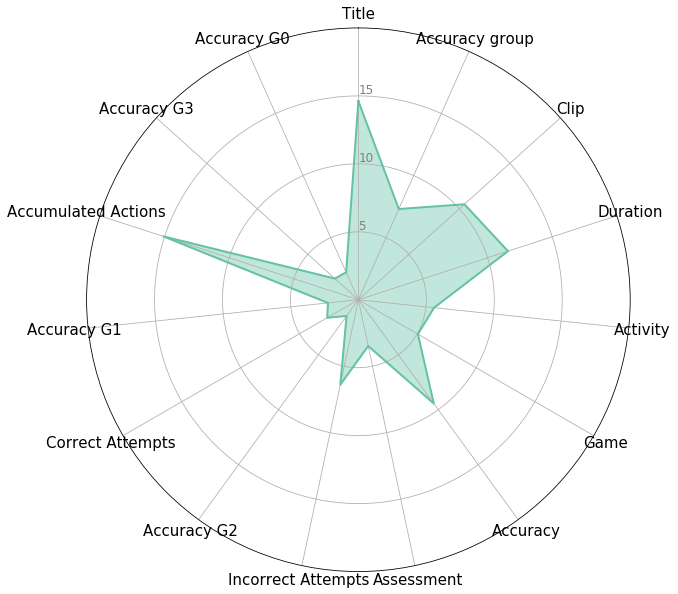

In [169]:
xgb_feature_imp = xgb_model.get_score(importance_type='total_cover')
df_imp = pd.DataFrame(xgb_feature_imp, index=[0])
df_imp.columns = ['Title', 'Accuracy group', 'Clip', 'Duration',
                  'Activity', 'Game', 'Accuracy', 'Assessment',
                  'Incorrect Attempts', 'Accuracy G2', 
                  'Correct Attempts', 'Accuracy G1', 
                  'Accumulated Actions', 'Accuracy G3', 'Accuracy G0']
df_imp = df_imp.div(df_imp.sum(1), axis=0)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
    
# Loop to plot
for row in range(0, len(df_imp.index)):
    make_spider(df_imp,  row=row, title='Feature Importance', color=my_palette(row))
plt.savefig(f'img/feature_importance_xgb.png', dpi = 300, bbox_inches = 'tight')

## Train CATBOOSTING model

In [14]:
cat_models,pred_cat = cat_boosting(X, y,X_test, all_features)

Training on fold 1
0:	learn: 0.4382062	test: 0.4410011	best: 0.4410011 (0)	total: 70.5ms	remaining: 7m 3s
500:	learn: 0.5291617	test: 0.5130889	best: 0.5144572 (484)	total: 7.04s	remaining: 1m 17s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5144571649
bestIteration = 484

Shrink model to first 485 iterations.
Fold 1 finished in 0:00:13.711837
____________________________________________________________________________________________

------------------------------
OOF QWK: 0.07450997421597794
------------------------------
Training on fold 2
0:	learn: 0.4661891	test: 0.4367465	best: 0.4367465 (0)	total: 19.9ms	remaining: 1m 59s
500:	learn: 0.5304536	test: 0.5055979	best: 0.5056277 (482)	total: 5.38s	remaining: 59.1s
1000:	learn: 0.5600270	test: 0.5031572	best: 0.5115098 (713)	total: 10.7s	remaining: 53.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5115097816
bestIteration = 713

Shrink model to first 714 iterations.
Fold 2 finished in

In [16]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['accuracy_group'] = np.round(pred_cat).astype('int')
sample_submission.to_csv('sample_submission_cat.csv', index=False)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [140]:
X['session_title'].nunique()

5

In [141]:
X_train_dummy, X_test_dummy = Convert_categorical_variables(X, X_test, ['session_title'])

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [143]:
xgb_model_dummy,pred_xgb_dummy = model_XGBOOST(X_train_dummy, y,X_test_dummy,5)

choen_kappa_score : 0.5166805613517007
choen_kappa_score : 0.5061318690102155
choen_kappa_score : 0.4974334951908197
choen_kappa_score : 0.5037038309893107
choen_kappa_score : 0.5010324976686563
Mean score: 0.5049964508421406


# Visualiztions

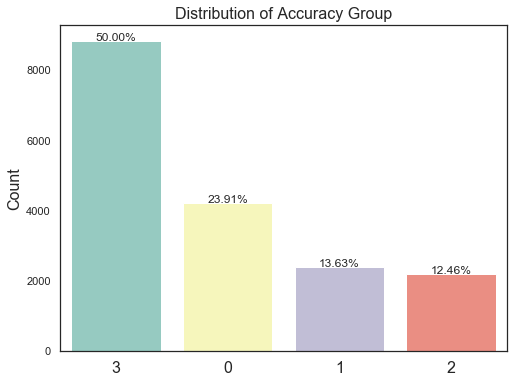

In [257]:
plot_count('accuracy_group', 'Accuracy Group', 'Accuracy Group', train_labels, size=2)

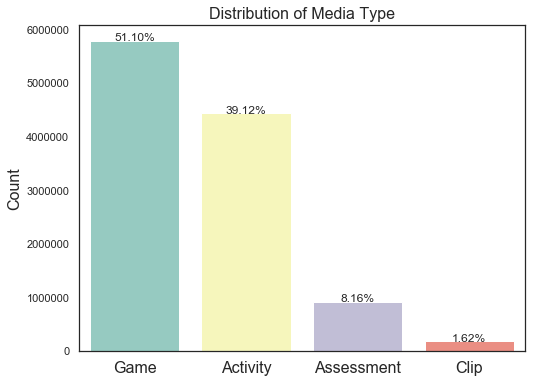

In [255]:
plot_count('type', 'Media Type', 'Media Type', train, size=2)